# Tratamiento de imágenes  2024 - Entregable 1
# Fecha de entrega: Jueves 18/4

**Importante:** En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:
* El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes**  del zip. 
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

**No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso**. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).
   

In [1]:
# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = './imagenes'

In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage.restoration import denoise_nl_means, wiener, richardson_lucy
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import convolve
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ----------------
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------


## 1) Líneas de nivel

Escribir un programa que reciba una imagen y un conjunto de valores y muestre las líneas de nivel correspondientes a dichos valores. Para ello implementar el algoritmo marching squares (Ver por ejemplo: https://en.wikipedia.org/wiki/Marching_squares).

Aplicarlo a imágenes naturales y artificiales y comparar los resultados con los de la función contour (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html). 

Imágenes artificiales sugeridas: cono.png, pliegues.png, oclusion.png


In [3]:
def obtener_imagen_binaria(I, nivel):
    height, width = I.shape
    J = np.empty((height, width), dtype=I.dtype)
    for i in range(height):
        for j in range(width):
            if I[i, j] >= nivel:
                J[i,j] = 1
            else:
                J[i,j] = 0
    return J

def generar_matriz_de_casos(I):
    height, width = I.shape
    cases_matrix = np.empty((height-1, width-1), dtype=I.dtype)
    for i in range(height-1):
        for j in range(width-1):
            cuatro_esquinas = np.array([[I[i, j],    I[i, j+1]],
                                        [I[i+1, j],  I[i+1, j+1]]])
            cases_matrix[i, j] = (cuatro_esquinas[0,0]<<3)+(cuatro_esquinas[0,1]<<2)+(cuatro_esquinas[1,1]<<1)+(cuatro_esquinas[1,0]<<0)
    return cases_matrix

def transformar_coordenadas_y_plotear_linea(i1, j1, i2, j2, nivel, cmap):
    x1, y1 = j1, i1
    x2, y2 = j2, i2
    plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

def plotear_cuadrante(img, caso:int, i, j, nivel, cmap):
    if caso in [5, 7, 8]:
        i1 = i + interpolacion_lineal(img[i,j], img[i+1,j], nivel)
        j1 = j
        i2 = i
        j2 = j + interpolacion_lineal(img[i,j], img[i,j+1], nivel)

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

    if caso in [2, 5, 13]:
        i1 = i + 1
        j1 = j + interpolacion_lineal(img[i+1,j], img[i+1,j+1], nivel)
        i2 = i + interpolacion_lineal(img[i,j+1], img[i+1,j+1], nivel)
        j2 = j + 1

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

    if caso in [6, 9]:
        i1 = i
        j1 = j + interpolacion_lineal(img[i,j], img[i,j+1], nivel)
        i2 = i + 1
        j2 = j + interpolacion_lineal(img[i+1,j], img[i+1,j+1], nivel)

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

    if caso in [1, 14, 10]:
        i1 = i + interpolacion_lineal(img[i,j], img[i+1,j], nivel)
        j1 = j
        i2 = i + 1
        j2 = j + interpolacion_lineal(img[i+1,j], img[i+1,j+1], nivel)

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

    if caso in [3, 12]:
        i1 = i + interpolacion_lineal(img[i,j], img[i+1,j], nivel)
        j1 = j
        i2 = i + interpolacion_lineal(img[i,j+1], img[i+1,j+1], nivel)
        j2 = j + 1

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

    if caso in [4, 10, 11]:
        i1 = i
        j1 = j + interpolacion_lineal(img[i,j], img[i,j+1], nivel)
        i2 = i + interpolacion_lineal(img[i,j+1], img[i+1,j+1], nivel)
        j2 = j + 1

        x1, y1 = j1, i1
        x2, y2 = j2, i2
        plt.plot([x1, x2], [y1, y2], label=nivel, color=cmap(nivel))

def interpolacion_lineal(p1, p2, nivel):
    return np.abs((nivel-p1)/(p2-p1))

def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper right')

In [4]:
def lineas_nivel(img, levels):
    """
    Genera líneas de nivel de una imagen dada.
    Muestra las líneas de nivel sobre la figura que se encuentre activa

    Args:
        img (array 2D): Imagen de entrada.
        levels (list): Lista de niveles.

    Returns:
        None
    """

    img = img.copy()
    cmap = plt.get_cmap('viridis', lut=max(levels))
    for nivel in levels:
        binary_matrix = obtener_imagen_binaria(img, nivel)
        cases_matrix = generar_matriz_de_casos(binary_matrix)
        rows, cols = cases_matrix.shape
        for i in range(rows):
            for j in range(cols):
                plotear_cuadrante(img, cases_matrix[i,j], i, j, nivel, cmap)
    legend_without_duplicate_labels(plt)
    return

/tmp/ipykernel_6895/1266019454.py:89: RuntimeWarning: overflow encountered in scalar subtract
  return np.abs((nivel-p1)/(p2-p1))


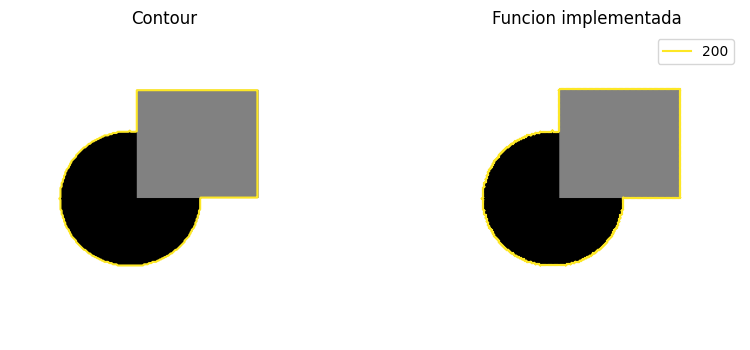

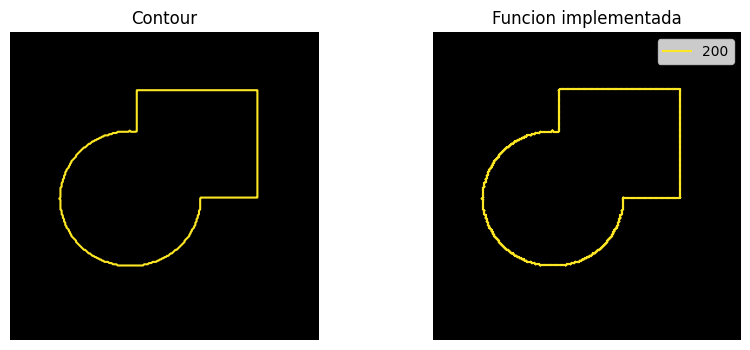

In [5]:
# Ejemplo de prueba: lineas_nivel y plt.contour deberían ser intercambiables

I = imread(os.path.join(dir_base_imagenes, 'oclusion.bmp'))
if I.ndim>2:
    I = I[:,:,0]


# muestra las líneas de nivel 100 y 200 sobre la imagen seleccionada

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].imshow(I, cmap='gray')
axs[0].contour(I, levels=[100, 200])
axs[0].axis('off')
axs[0].set_title("Contour")

axs[1].imshow(I, cmap='gray')
axs[1].set_title("Funcion implementada")
axs[1].axis('off')
lineas_nivel(I, levels=[100, 200])

# muestra las líneas de nivel 100 y 200 sobre una imagen vacía

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].imshow(np.zeros_like(I), cmap='gray')
axs[0].contour(I, levels=[100, 200])
axs[0].axis('off')
axs[0].set_title("Contour")

axs[1].imshow(np.zeros_like(I), cmap='gray')
axs[1].set_title("Funcion implementada")
axs[1].axis('off')
lineas_nivel(I, levels=[100, 200])


## 2) Histograma y Ecualización

Imágenes sugeridas: parot2.png, parot2.png, strike1.png, strike2.png

**a)** Implementar una función que calcule el histograma e histograma acumulado de una imagen. Mostrar resultados para las imágenes parot1.png y parot2.png con diverso número de bins (bins=10, bins=100, bins=256). 

In [6]:
def histograma(img, bins, rango=None):
    """
    Calcula el histograma de una imagen.
    Devuelve el histograma y los bins correspondientes.

    Args:
        imagen (ndarray): La imagen de entrada.
        bins (int): El número de bins a utilizar.
        rango (float, float), opcional. Rango mínimo y máximo para los bins. Si no
                                        se pasa, se toma el mínimo y máximo de la imagen

    Returns:
        counts (1D-array de largo bins): Cantidad de muestras en cada bin
        bin_edges (1D-array de largo bins +1): Los bordes de los bins utilizados para calcular el histograma.
    """

    if rango is None:
        rango = (np.min(img), np.max(img))

    bin_width = (rango[1] - rango[0] + 1) / bins

    # Bordes de los bins
    bin_edges = [rango[0] + n*bin_width for n in range(bins)]
    bin_edges.append(rango[1])

    # Cantidad de muestras en cada bin
    counts = np.zeros(bins)
    filas, columnas = np.shape(img)
    for i in range(filas):
        for j in range(columnas):
            if rango[0] <= img[i,j] <= rango[1]:
                bin_index = int((img[i,j] - rango[0]) / bin_width)
                counts[bin_index] += 1

    return counts, bin_edges


def histogramaAcumulado(img, bins, rango=None):
    """
    Calcula el histograma acumulado de una imagen.
    Devuelve el histograma acumulado y los bins correspondientes.

    Args:
        imagen (ndarray): La imagen de entrada.
        bins (int): El número de bins a utilizar.
        rango (float, float), opcional. Rango mínimo y máximo para los bins. Si no
                                        se pasa, se toma el mínimo y máximo de la imagen

    Returns:
        counts (1D-array de largo bins): Cantidad de muestras acumuladas en cada bin
        bin_edges (1D-array de largo bins +1): Los bordes de los bins utilizados.
    """

    count, bin_edges = histograma(img, bins, rango)
    count_acum = np.cumsum(count)
    return count_acum, bin_edges

Text(0.5, 1.0, 'bins = 256')

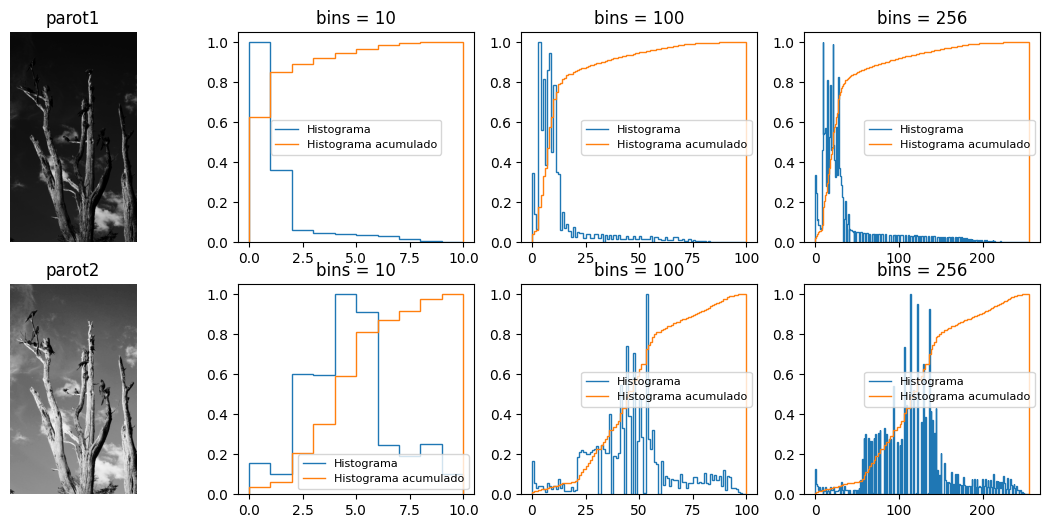

In [7]:
parot1 = imread(os.path.join(dir_base_imagenes, 'parot1.png'))
parot2 = imread(os.path.join(dir_base_imagenes, 'parot2.png'))

fig, ax = plt.subplots(2,4, figsize=(14,6))
ax[0,0].imshow(parot1, cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('parot1')

parot1_hist_bin10 = histograma(parot1, bins=10)[0]
parot1_histAcum_bin10 = histogramaAcumulado(parot1, bins=10)[0]
ax[0,1].stairs(parot1_hist_bin10/np.max(parot1_hist_bin10), label='Histograma')
ax[0,1].stairs(parot1_histAcum_bin10/np.max(parot1_histAcum_bin10), label='Histograma acumulado')
ax[0,1].legend(fontsize=8)
ax[0,1].set_title('bins = 10')

parot1_hist_bin100 = histograma(parot1, bins=100)[0]
parot1_histAcum_bin100 = histogramaAcumulado(parot1, bins=100)[0]
ax[0,2].stairs(parot1_hist_bin100/np.max(parot1_hist_bin100), label='Histograma')
ax[0,2].stairs(parot1_histAcum_bin100/np.max(parot1_histAcum_bin100), label='Histograma acumulado')
ax[0,2].legend(fontsize=8)
ax[0,2].set_title('bins = 100')

parot1_hist_bin256 = histograma(parot1, bins=256)[0]
parot1_histAcum_bin256 = histogramaAcumulado(parot1, bins=256)[0]
ax[0,3].stairs(parot1_hist_bin256/np.max(parot1_hist_bin256), label='Histograma')
ax[0,3].stairs(parot1_histAcum_bin256/np.max(parot1_histAcum_bin256), label='Histograma acumulado')
ax[0,3].legend(fontsize=8)
ax[0,3].set_title('bins = 256')

ax[1,0].imshow(parot2, cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('parot2')

parot2_hist_bin10 = histograma(parot2, bins=10)[0]
parot2_histAcum_bin10 = histogramaAcumulado(parot2, bins=10)[0]
ax[1,1].stairs(parot2_hist_bin10/np.max(parot2_hist_bin10), label='Histograma')
ax[1,1].stairs(parot2_histAcum_bin10/np.max(parot2_histAcum_bin10), label='Histograma acumulado')
ax[1,1].legend(fontsize=8)
ax[1,1].set_title('bins = 10')

parot2_hist_bin100 = histograma(parot2, bins=100)[0]
parot2_histAcum_bin100 = histogramaAcumulado(parot2, bins=100)[0]
ax[1,2].stairs(parot2_hist_bin100/np.max(parot2_hist_bin100), label='Histograma')
ax[1,2].stairs(parot2_histAcum_bin100/np.max(parot2_histAcum_bin100), label='Histograma acumulado')
ax[1,2].legend(fontsize=8)
ax[1,2].set_title('bins = 100')

parot2_hist_bin256 = histograma(parot2, bins=256)[0]
parot2_histAcum_bin256 = histogramaAcumulado(parot2, bins=256)[0]
ax[1,3].stairs(parot2_hist_bin256/np.max(parot2_hist_bin256), label='Histograma')
ax[1,3].stairs(parot2_histAcum_bin256/np.max(parot2_histAcum_bin256), label='Histograma acumulado')
ax[1,3].legend(fontsize=8)
ax[1,3].set_title('bins = 256')

Se puede observar como parot2 tiene un histograma más distribuido en los niveles de grices y por lo tanto un histograma acumulado más cercano a una recta. Esto se refleja en una mejoría del contraste global y una mejor apariencia

**b)** Comparar los histogramas con la salida de la función *histogram()* de numpy para las mismas imágenes y mismos bins.

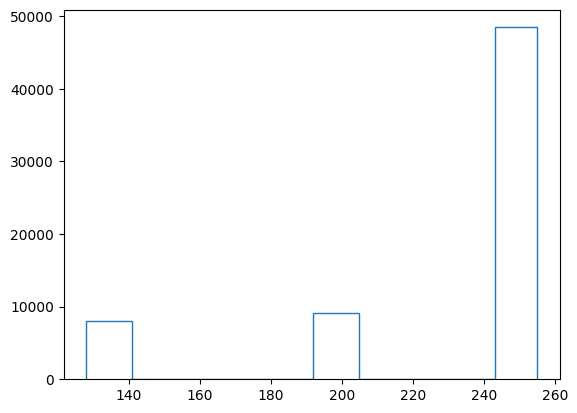

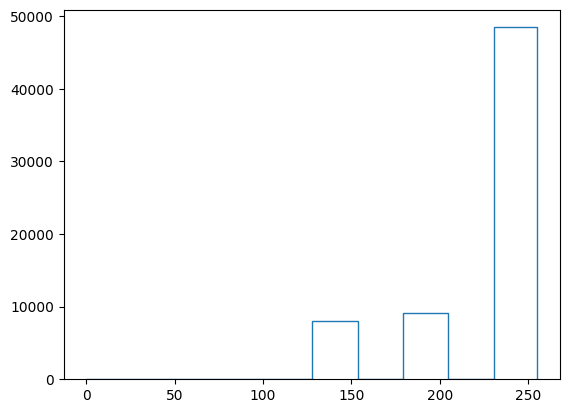

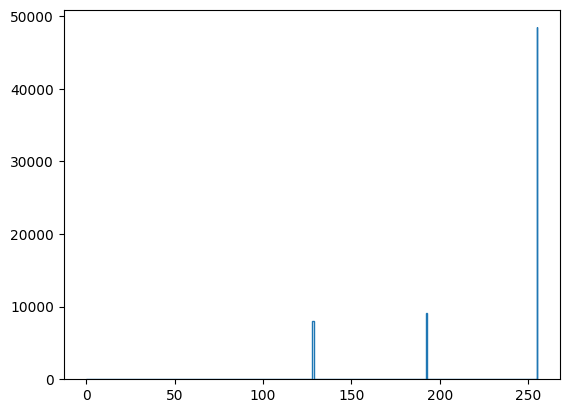

In [8]:
# Ejemplo de prueba: histograma y np.histogram deberían ser intercambiables

I = imread(os.path.join(dir_base_imagenes, 'oclusion.bmp'))
if I.ndim>2:
    I = I[:,:,0]


# calcula y muestra el histograma
# counts, bin_edges = np.histogram(I, 10)
counts, bin_edges = histograma(I, 10)

plt.figure()
plt.stairs(counts, bin_edges) #u otra forma de graficar

#-----------------------------------------

# calcula y muestra el histograma
# counts, bin_edges = np.histogram(I, 10, (0,255))
counts, bin_edges = histograma(I, 10, (0,255))

plt.figure()
plt.stairs(counts, bin_edges) #u otra forma de graficar

#-----------------------------------------

# calcula y muestra el histograma
# counts, bin_edges = np.histogram(I, 256, (0,255))
counts, bin_edges = histograma(I, 256, (0,255))

plt.figure()
plt.stairs(counts, bin_edges) #u otra forma de graficar



**c)** **Explicar en qué consiste** el método *`midway equalization`* e **implementar una función** que aplique dicha ecualización a un par de imágenes dadas, con valores enteros entre 0 y 255. Usar como referencia el siguiente artículo disponible en IPOL: https://www.ipol.im/pub/art/2016/140/

El mismo artículo presenta en la sección 2, en _Algorithm 2_, una implementación para el caso de dos imágenes.



In [9]:
def midway_eq(img1, img2):
    """
    Ecualización midway para un par de imágenes que toman valores en uint8.

    Args:
        img1 (ndarray uint8): Primer imagen a ecualizar.
        img2 (ndarray uint8): Segunda imagen a ecualizar.

    Returns:
        img1_eq (ndarray): Primer imagen de entrada ecualizada con método midway equalization
        img2_eq (ndarray): Segunda imagen de entrada ecualizada con método midway equalization

    """

    # histogramas acumulados
    count1, _ = histogramaAcumulado(img1, 256, (0, 255))
    count2, _ = histogramaAcumulado(img2, 256, (0, 255))

    # normalizo histogramas acumulados
    count1 = count1/np.max(count1)
    count2 = count2/np.max(count2)

    # calculo f1
    l = 0
    f_1 = np.empty(256)
    for k in range(256):
        while count1[k] > count2[l]:    # encontrar l / count1(k) = count2(l)
            l = l + 1
        f_1[k] = (1/2)*(k+l)

    # calculo f2
    l = 0
    f_2 = np.empty(256)
    for k in range(256):
        while count2[k] > count1[l]:    # encontrar l / count2(k) = count1(l)
            l = l + 1
        f_2[k] = (1/2)*(k+l)

    # aplico f1 a img1
    img1_eq = np.empty(img1.shape)
    filas1, columnas1 = img1.shape
    for i in range(filas1):
        for j in range(columnas1):
            img1_eq[i,j] = f_1[img1[i,j]]

    # aplico f2 a img2
    img2_eq = np.empty(img2.shape)
    filas2, columnas2 = img2.shape
    for i in range(filas2):
        for j in range(columnas2):
            img2_eq[i,j] = f_2[img2[i,j]]

    return img1_eq, img2_eq

La idea de midway equalization es poder encontrar un histograma acumulado que este a mitad de camino entre los histogramas acumulados de dos imágenes distintas, y ajustar dichas imágenes para que presenten ambas dicho histograma acumulado intermedio. De esta manera, ambas imágenes quedan con un contraste similar, ya que sus tonos de grices varían en un rango similar.

**d)** Aplique midway equalization entre dos imágenes (por ejemplo, parot1.png y parot2.png y/o entre danse1.png y danse2.png).

Muestre y analice los resultados (imágenes originales y resultantes, junto sus histogramas acumulados).

**_Opcional:_**
modificar la función de `midway_eq()` para que funcione para imágenes RGB (*strike1.png* y *strike2.png*, por ejemplo) y analizar los histogramas por canal.

In [10]:

img1 = imread(os.path.join(dir_base_imagenes, 'parot1.png'))
img2 = imread(os.path.join(dir_base_imagenes, 'parot2.png'))

# img1 = imread(os.path.join(dir_base_imagenes, 'danse1.png'))
# img2 = imread(os.path.join(dir_base_imagenes, 'danse2.png'))

# Ecualizar ambas imágenes

img1_eq, img2_eq = midway_eq(img1, img2)

<Figure size 640x480 with 0 Axes>

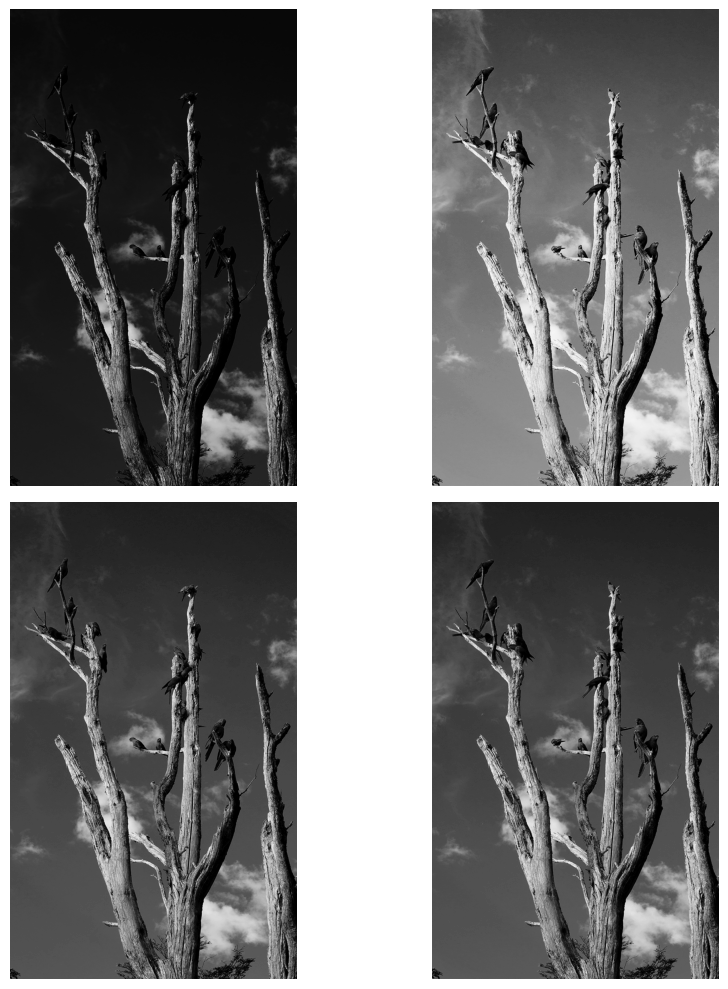

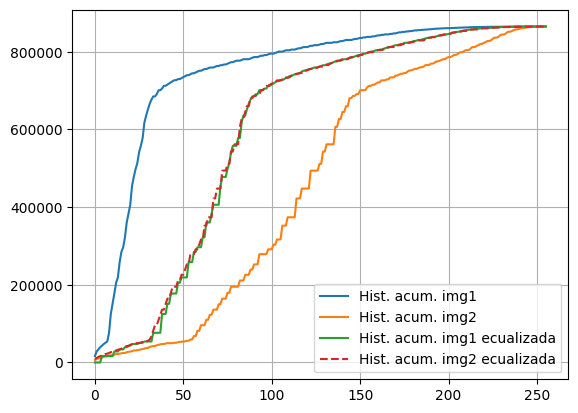

In [11]:
# Graficar imagenes
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(img1, cmap='gray'), ax[0,0].axis('off')
ax[0,1].imshow(img2, cmap='gray'), ax[0,1].axis('off')
ax[1,0].imshow(img1_eq, cmap='gray'), ax[1,0].axis('off')
ax[1,1].imshow(img2_eq, cmap='gray'), ax[1,1].axis('off')
plt.tight_layout()
plt.show()

# Calcular histogramas acumulados
H1 = histogramaAcumulado(img1, 256, (0, 255))[0]
H2 = histogramaAcumulado(img2, 256, (0, 255))[0]
H_img1_eq = histogramaAcumulado(img1_eq, 256, (0, 255))[0]
H_img2_eq = histogramaAcumulado(img2_eq, 256, (0, 255))[0]

# Graficar histogramas acumulados
plt.figure()
plt.plot(H1 , label='Hist. acum. img1')
plt.plot(H2, label='Hist. acum. img2')
plt.plot(H_img1_eq, label='Hist. acum. img1 ecualizada')
plt.plot(H_img2_eq, '--', label='Hist. acum. img2 ecualizada')
plt.grid()
plt.legend()
plt.show()

##  3) Restauración de imágenes con ruido

**a) A partir de una imagen original, generar imágenes con diferentes niveles de ruido gaussiano (por ejemplo σ=5, 20, 40) y ruido “sal y pimienta” (por ejemplo p=0.1, 0.5, 0.8).**

Imágenes sugeridas: peppers.png, baboon.png, etc (pasadas a gris en caso que estén en colores)   
Otras [imágenes estándar](http://en.wikipedia.org/wiki/Standard_test_image) se pueden encontrar en http://sipi.usc.edu/database/database.php?volume=misc    

In [12]:
def add_gaussian_noise(I, sigma):
    """
    Contaminar imagen con ruido Gaussiano de desviación estándar sigma.

    Args:
        I (ndarray): La imagen de entrada.
        sigma (float): Desviación estándar del ruido.

    Returns:
        J (ndarray): La imagen contaminada con ruido Gaussiano de desviación estándar sigma

    """

    ruido_gaussiano = np.random.normal(0, sigma, np.shape(I))
    J = I + ruido_gaussiano

    return J

def add_saltpepper_noise(I,p):
    """
    Contaminar imagen con ruido sal y pimienta. Cada pixel tiene probabilidad p de ser contaminado.
    Se asume que, dado un pixel contaminado, la asignación de 0 o 255 (pepper y salt, respectivamente) es equiprobale.

    Args:
        I (ndarray): La imagen de entrada.
        p (float): Probabilidad de que un pixel sea contaminado.

    Returns:
        J (ndarray): La imagen contaminada con ruido sal y pimienta

    """

    J = np.copy(I)
    random_matrix = np.random.random(J.shape)

    # cuando toca ruido relleno con nan
    J = np.where(random_matrix < p, np.nan, J)

    # relleno con sal o pimienta en las celdad nan
    nan_indices = np.isnan(J)
    J[nan_indices] = np.random.choice([0, 255], size=np.sum(nan_indices))

    return J

<Figure size 640x480 with 0 Axes>

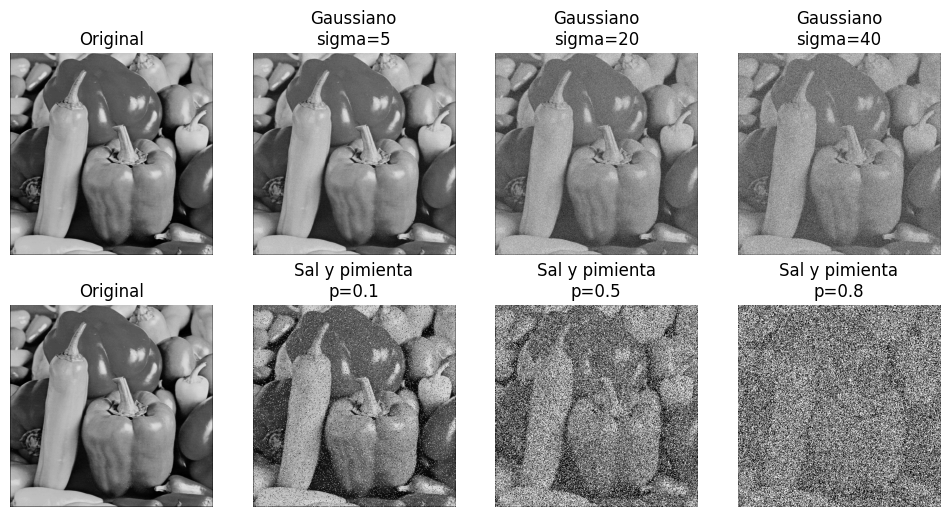

In [13]:
peppers = cv2.imread(os.path.join(dir_base_imagenes, 'peppers.png'), cv2.IMREAD_GRAYSCALE)

fig = plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0,0].imshow(peppers, cmap='gray')
ax[0,0].set_title('Original')
ax[0,0].axis('off')

ax[0,1].imshow(add_gaussian_noise(peppers, 5), cmap='gray')
ax[0,1].set_title('Gaussiano\nsigma=5')
ax[0,1].axis('off')

ax[0,2].imshow(add_gaussian_noise(peppers, 20), cmap='gray')
ax[0,2].set_title('Gaussiano\nsigma=20')
ax[0,2].axis('off')

ax[0,3].imshow(add_gaussian_noise(peppers, 40), cmap='gray')
ax[0,3].set_title('Gaussiano\nsigma=40')
ax[0,3].axis('off')

ax[1,0].imshow(peppers, cmap='gray')
ax[1,0].set_title('Original')
ax[1,0].axis('off')

ax[1,1].imshow(add_saltpepper_noise(peppers, 0.1), cmap='gray')
ax[1,1].set_title('Sal y pimienta\np=0.1')
ax[1,1].axis('off')

ax[1,2].imshow(add_saltpepper_noise(peppers, 0.5), cmap='gray')
ax[1,2].set_title('Sal y pimienta\np=0.5')
ax[1,2].axis('off')

ax[1,3].imshow(add_saltpepper_noise(peppers, 0.8), cmap='gray')
ax[1,3].set_title('Sal y pimienta\np=0.8')
ax[1,3].axis('off')

plt.show()
plt.close()

**b) Procesar las imágenes de (a) con**
* filtros de media de diverso tamaño (implementar)
* filtros de mediana de diverso tamaño (implementar)
* Non local means (usar implementación de OpenCV y/o de scikit-image). 

**Para Non local means: explicar en qué se basa el algoritmo y sus parámetros principales.**

In [14]:
def meanFilter(I, filter_size, padding_mode='edge'):
    """
    Aplica filtro de media a la imagen

    Args:
        I (np.array): imagen a filtrar
        filter_size (int): Dimensión del filtro cuadrado.
                           Ejemplo: si se quiere un filtro de 3x3 se debe pasar filter_size = 1
        padding_mode (str, optional): eleccion del padding a utilizar. Defaults to 'edge'.

    Returns:
        np.array: imagen filtrada
    """

    J = np.empty(I.shape)
    I_pad = np.pad(I.copy(), filter_size, padding_mode)

    filas, columnas = I_pad.shape
    for i in range(filas - filter_size*2):
        for j in range(columnas - filter_size*2):
            square = I_pad[i:i+filter_size*2+1, j:j+filter_size*2+1]
            J[i,j] = int(np.mean(square))

    return J

def medianFilter(I, filter_size, padding_mode='edge'):
    """
    Aplica filtro de mediana a la imagen

    Args:
        I (np.array): imagen a filtrar
        filter_size (int): Dimensión del filtro cuadrado.
                           Ejemplo: si se quiere un filtro de 3x3 se debe pasar filter_size = 1
        padding_mode (str, optional): eleccion del padding a utilizar. Defaults to 'edge'.

    Returns:
        np.array: imagen filtrada
    """

    J = np.empty(I.shape)
    I_pad = np.pad(I.copy(), filter_size, padding_mode)

    filas, columnas = I_pad.shape
    for i in range(filas - filter_size*2):
        for j in range(columnas - filter_size*2):
            square = I_pad[i:i+filter_size*2+1, j:j+filter_size*2+1]
            J[i,j] = int(np.median(square))

    return J

Restauración de imagenes con ruido gaussino

/tmp/ipykernel_6895/928169181.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return f"Restauración con\n{filtro}\nRMSE={round(np.sqrt(mean_squared_error(img_original, img_restaurada)), 2)} PSNR={round(peak_signal_noise_ratio(img_original, img_restaurada),2)}"


<Figure size 640x480 with 0 Axes>

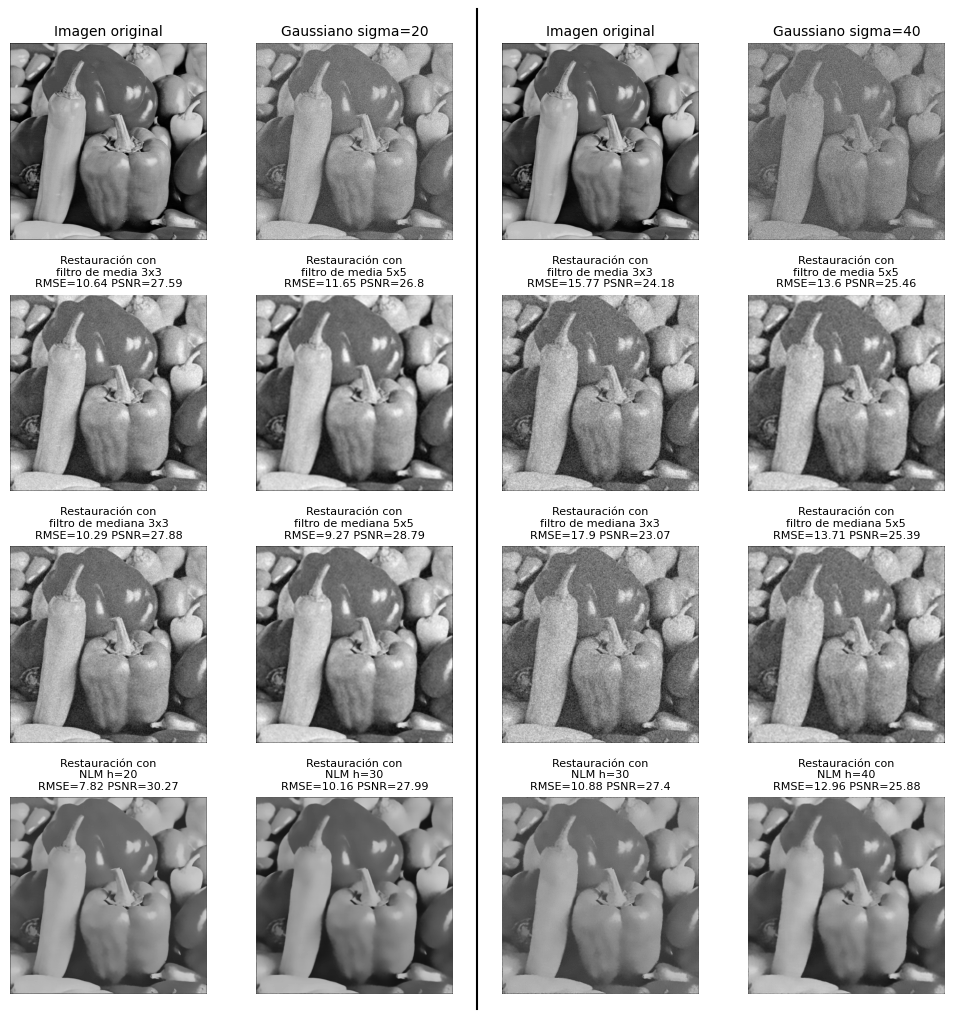

In [15]:
gaussian_20 = add_gaussian_noise(peppers, 20)
gaussian_20_mean_1 = meanFilter(gaussian_20, 1)
gaussian_20_mean_2 = meanFilter(gaussian_20, 2)
gaussian_20_median_1 = medianFilter(gaussian_20, 1)
gaussian_20_median_2 = medianFilter(gaussian_20, 2)
gaussian_20_nlm_20 = denoise_nl_means(gaussian_20, h=20)
gaussian_20_nlm_30 = denoise_nl_means(gaussian_20, h=30)

gaussian_40 = add_gaussian_noise(peppers, 40)
gaussian_40_mean_1 = meanFilter(gaussian_40, 1)
gaussian_40_mean_2 = meanFilter(gaussian_40, 2)
gaussian_40_median_1 = medianFilter(gaussian_40, 1)
gaussian_40_median_2 = medianFilter(gaussian_40, 2)
gaussian_40_nlm_30 = denoise_nl_means(gaussian_40, h=30)
gaussian_40_nlm_40 = denoise_nl_means(gaussian_40, h=40)


def title(filtro:str, img_original, img_restaurada):
    return f"Restauración con\n{filtro}\nRMSE={round(np.sqrt(mean_squared_error(img_original, img_restaurada)), 2)} PSNR={round(peak_signal_noise_ratio(img_original, img_restaurada),2)}"

fig = plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(10, 10))#figsize=(10, 8)
fig.add_artist(plt.Line2D([0.5, 0.5], [0, 1], color='black'))

## gaussian 20

ax[0,0].imshow(peppers, cmap='gray')
ax[0,0].set_title(f'Imagen original', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(gaussian_20, cmap='gray')
ax[0,1].set_title(f'Gaussiano sigma=20', fontsize=10)
ax[0,1].axis('off')

ax[1,0].imshow(gaussian_20_mean_1, cmap='gray')
ax[1,0].set_title(title("filtro de media 3x3", peppers, gaussian_20_mean_1), fontsize=8)
ax[1,0].axis('off')

ax[1,1].imshow(gaussian_20_mean_2, cmap='gray')
ax[1,1].set_title(title("filtro de media 5x5", peppers, gaussian_20_mean_2), fontsize=8)
ax[1,1].axis('off')

ax[2,0].imshow(gaussian_20_median_1, cmap='gray')
ax[2,0].set_title(title("filtro de mediana 3x3", peppers, gaussian_20_median_1), fontsize=8)
ax[2,0].axis('off')

ax[2,1].imshow(gaussian_20_median_2, cmap='gray')
ax[2,1].set_title(title("filtro de mediana 5x5", peppers, gaussian_20_median_2), fontsize=8)
ax[2,1].axis('off')

ax[3,0].imshow(gaussian_20_nlm_20, cmap='gray')
ax[3,0].set_title(title("NLM h=20", peppers, gaussian_20_nlm_20), fontsize=8)
ax[3,0].axis('off')

ax[3,1].imshow(gaussian_20_nlm_30, cmap='gray')
ax[3,1].set_title(title("NLM h=30", peppers, gaussian_20_nlm_30), fontsize=8)
ax[3,1].axis('off')

## gaussian 40

ax[0,2].imshow(peppers, cmap='gray')
ax[0,2].set_title(f'Imagen original', fontsize=10)
ax[0,2].axis('off')

ax[0,3].imshow(gaussian_40, cmap='gray')
ax[0,3].set_title(f'Gaussiano sigma=40', fontsize=10)
ax[0,3].axis('off')

ax[1,2].imshow(gaussian_40_mean_1, cmap='gray')
ax[1,2].set_title(title("filtro de media 3x3", peppers, gaussian_40_mean_1), fontsize=8)
ax[1,2].axis('off')

ax[1,3].imshow(gaussian_40_mean_2, cmap='gray')
ax[1,3].set_title(title("filtro de media 5x5", peppers, gaussian_40_mean_2), fontsize=8)
ax[1,3].axis('off')

ax[2,2].imshow(gaussian_40_median_1, cmap='gray')
ax[2,2].set_title(title("filtro de mediana 3x3", peppers, gaussian_40_median_1), fontsize=8)
ax[2,2].axis('off')

ax[2,3].imshow(gaussian_40_median_2, cmap='gray')
ax[2,3].set_title(title("filtro de mediana 5x5", peppers, gaussian_40_median_2), fontsize=8)
ax[2,3].axis('off')

ax[3,2].imshow(gaussian_40_nlm_30, cmap='gray')
ax[3,2].set_title(title("NLM h=30", peppers, gaussian_40_nlm_30), fontsize=8)
ax[3,2].axis('off')

ax[3,3].imshow(gaussian_40_nlm_40, cmap='gray')
ax[3,3].set_title(title("NLM h=40", peppers, gaussian_40_nlm_40), fontsize=8)
ax[3,3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

Restauración de imagenes con ruido sal y pimienta

/tmp/ipykernel_6895/1458007756.py:18: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return f"Restauración con\n{filtro}\nRMSE={round(np.sqrt(mean_squared_error(img_original, img_restaurada)), 2)} PSNR={round(peak_signal_noise_ratio(img_original, img_restaurada),2)}"


<Figure size 640x480 with 0 Axes>

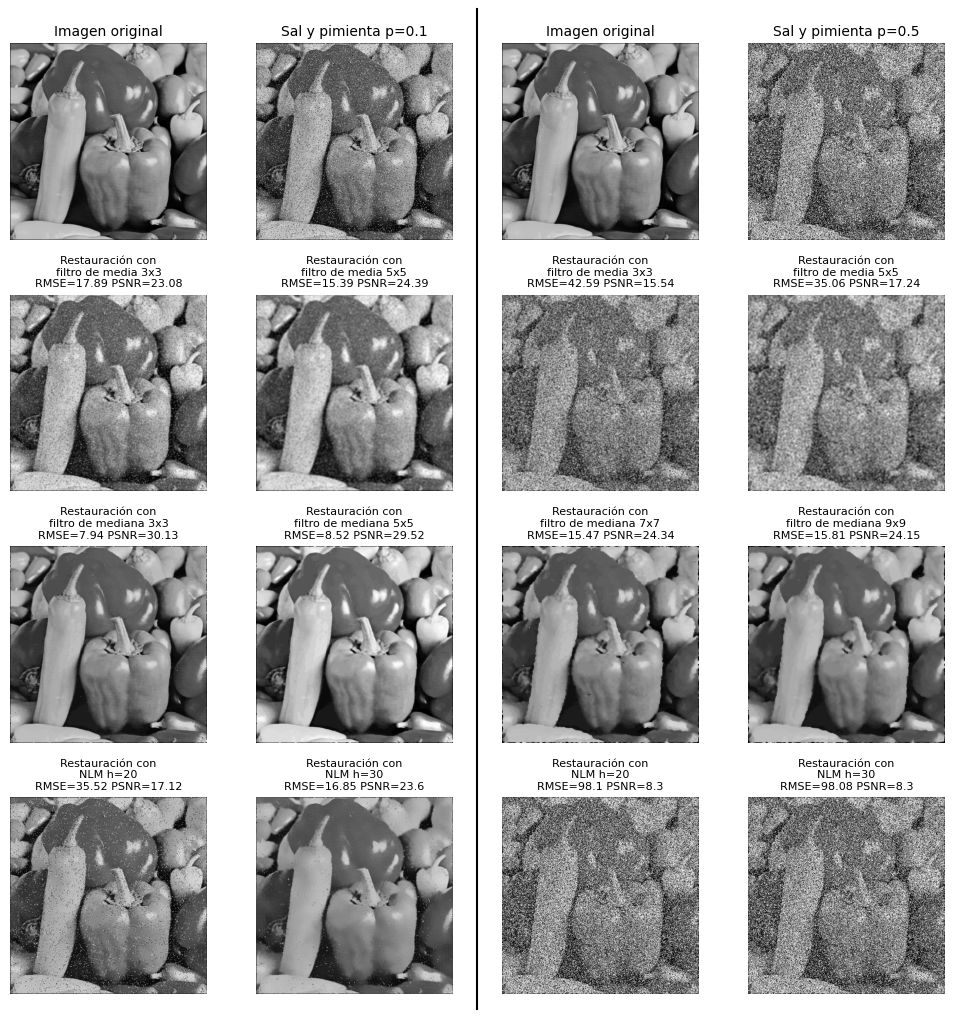

In [16]:
saltpepper_01 = add_saltpepper_noise(peppers, 0.1)
saltpepper_01_mean_1 = meanFilter(saltpepper_01, 1)
saltpepper_01_mean_2 = meanFilter(saltpepper_01, 2)
saltpepper_01_median_1 = medianFilter(saltpepper_01, 1)
saltpepper_01_median_2 = medianFilter(saltpepper_01, 2)
saltpepper_01_nlm_20 = denoise_nl_means(saltpepper_01, h=20)
saltpepper_01_nlm_30 = denoise_nl_means(saltpepper_01, h=30)

saltpepper_05 = add_saltpepper_noise(peppers, 0.5)
saltpepper_05_mean_1 = meanFilter(saltpepper_05, 1)
saltpepper_05_mean_2 = meanFilter(saltpepper_05, 2)
saltpepper_05_median_3 = medianFilter(saltpepper_05, 3)
saltpepper_05_median_4 = medianFilter(saltpepper_05, 4)
saltpepper_05_nlm_20 = denoise_nl_means(saltpepper_05, h=20)
saltpepper_05_nlm_30 = denoise_nl_means(saltpepper_05, h=30)

def title(filtro:str, img_original, img_restaurada):
    return f"Restauración con\n{filtro}\nRMSE={round(np.sqrt(mean_squared_error(img_original, img_restaurada)), 2)} PSNR={round(peak_signal_noise_ratio(img_original, img_restaurada),2)}"

fig = plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(10, 10))#figsize=(10, 8)
fig.add_artist(plt.Line2D([0.5, 0.5], [0, 1], color='black'))

## saltpepper 01

ax[0,0].imshow(peppers, cmap='gray')
ax[0,0].set_title(f'Imagen original', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(saltpepper_01, cmap='gray')
ax[0,1].set_title(f'Sal y pimienta p=0.1', fontsize=10)
ax[0,1].axis('off')

ax[1,0].imshow(saltpepper_01_mean_1, cmap='gray')
ax[1,0].set_title(title("filtro de media 3x3", peppers, saltpepper_01_mean_1), fontsize=8)
ax[1,0].axis('off')

ax[1,1].imshow(saltpepper_01_mean_2, cmap='gray')
ax[1,1].set_title(title("filtro de media 5x5", peppers, saltpepper_01_mean_2), fontsize=8)
ax[1,1].axis('off')

ax[2,0].imshow(saltpepper_01_median_1, cmap='gray')
ax[2,0].set_title(title("filtro de mediana 3x3", peppers, saltpepper_01_median_1), fontsize=8)
ax[2,0].axis('off')

ax[2,1].imshow(saltpepper_01_median_2, cmap='gray')
ax[2,1].set_title(title("filtro de mediana 5x5", peppers, saltpepper_01_median_2), fontsize=8)
ax[2,1].axis('off')

ax[3,0].imshow(saltpepper_01_nlm_20, cmap='gray')
ax[3,0].set_title(title("NLM h=20", peppers, saltpepper_01_nlm_20), fontsize=8)
ax[3,0].axis('off')

ax[3,1].imshow(saltpepper_01_nlm_30, cmap='gray')
ax[3,1].set_title(title("NLM h=30", peppers, saltpepper_01_nlm_30), fontsize=8)
ax[3,1].axis('off')

## saltpepper 05

ax[0,2].imshow(peppers, cmap='gray')
ax[0,2].set_title(f'Imagen original', fontsize=10)
ax[0,2].axis('off')

ax[0,3].imshow(saltpepper_05, cmap='gray')
ax[0,3].set_title(f'Sal y pimienta p=0.5', fontsize=10)
ax[0,3].axis('off')

ax[1,2].imshow(saltpepper_05_mean_1, cmap='gray')
ax[1,2].set_title(title("filtro de media 3x3", peppers, saltpepper_05_mean_1), fontsize=8)
ax[1,2].axis('off')

ax[1,3].imshow(saltpepper_05_mean_2, cmap='gray')
ax[1,3].set_title(title("filtro de media 5x5", peppers, saltpepper_05_mean_2), fontsize=8)
ax[1,3].axis('off')

ax[2,2].imshow(saltpepper_05_median_3, cmap='gray')
ax[2,2].set_title(title("filtro de mediana 7x7", peppers, saltpepper_05_median_3), fontsize=8)
ax[2,2].axis('off')

ax[2,3].imshow(saltpepper_05_median_4, cmap='gray')
ax[2,3].set_title(title("filtro de mediana 9x9", peppers, saltpepper_05_median_4), fontsize=8)
ax[2,3].axis('off')

ax[3,2].imshow(saltpepper_05_nlm_20, cmap='gray')
ax[3,2].set_title(title("NLM h=20", peppers, saltpepper_05_nlm_20), fontsize=8)
ax[3,2].axis('off')

ax[3,3].imshow(saltpepper_05_nlm_30, cmap='gray')
ax[3,3].set_title(title("NLM h=30", peppers, saltpepper_05_nlm_30), fontsize=8)
ax[3,3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

_Respuesta NLM:_

El filtro Non Local Means estima cada píxel promediando todos los valores de los píxeles de la imagen, con mayor ponderación a aquellos que son considerados similares, independientemente de su localización en la imagen. Para evaluar si dos píxeles son similares se comparan ambos vecinajes de estos. Este filtro suele lograr menos pérdida en el detalle de la imagen.

Principales parámetros:
- patch_size: tamaño del parche/vecinaje utilizado para calcular las similitudes entre los píxeles.

- patch_distance: distancia máxima entre dos píxeles para considerarlos en el cálculo de similitud. Reducir este valor limitará la distancia a la que se buscan píxeles similares

- h: parámetro de suavizado. Controla cuánto se debe filtrar la imagen. Valores más altos resultarán en una mayor reducción de ruido, pero también pueden llevar a una mayor pérdida de detalles.

**c) Cuantificar la reducción de ruido utilizando medidas adecuadas (PSNR, RMSE).**  
Indicar cuáles de los algoritmos son adecuados para cada tipo de ruido.

Las métricas a usar pueden encontrarse en [skimage.metrics ](https://scikit-image.org/docs/stable/api/skimage.metrics.html)

**Nota:** En caso que lo deseen, la parte de cuantificación puede realizarse en Fiji mediante el plugin SNR como se muestra en el video de Restauración.  
Para eso, se puede guardar las imágenes originales, ruidosas y restauradas generadas en el notebook y luego procesarlas con Fiji.  
El plugin se encuentra disponible en http://bigwww.epfl.ch/sage/soft/snr/.
También se encuentra como ejemplo el macro *Macro_noise.ijm* para generar las imagenes ruidosas y la restauración.

_Comentario:_


Se puede observar en las imágenes que para el ruido gaussiano funcionan mejor los filtros de media y Non-Local Means (NLM), mientras que para el ruido sal y pimienta funciona mejor el filtro de mediana.

El filtro de media calcula el promedio de los píxeles en su vecindad, lo que lo hace efectivo para imágenes contaminadas con ruido gaussiano, ya que distribuye el ruido de manera uniforme.

Por otro lado, el filtro NLM utiliza la similitud entre regiones de la imagen para estimar el valor de cada píxel, lo que lo hace más adecuado para imágenes con ruido gaussiano al utilizar información global de la imagen para suavizarla y preservar detalles y bordes.

En cuanto al filtro de mediana, al ser menos sensible a los valores extremos, resulta más efectivo para imágenes contaminadas con ruido de sal y pimienta.

## Transformada DFT

## 4) Movimiento lineal uniforme 

**a) Ver PSF y MTF del movimiento lineal uniforme (se provee una función que calcula la PSF a partir del largo y el ángulo del movimiento)**    

Para un cierto movimiento lineal, mostrar PSF y MTF. Analizar qué forma tiene la MTF.  

Aplicar el movimiento sobre una imagen y mostrar las imágenes original y degradada y sus transformadas.

In [17]:
from skimage import transform
import numpy as np

def motionPSF(largo=9,angulo_en_grados=0, sz=65):
    # Se genera una imagen cuadrada de lado sz y se pinta una linea horizontal
    # en el medio de la imagen de tamaño igual al largo
    f = np.zeros((sz,sz))
    f[sz // 2, sz // 2 - largo//2 : sz // 2 + largo//2 + 1]=1  # "//" hace una división entera
    # Luego se rota el angulo especificado
    f = transform.rotate(f,angulo_en_grados)
    # Finalmente se normaliza
    f = f/np.sum(f)
    return f

(-0.5, 399.5, 265.5, -0.5)

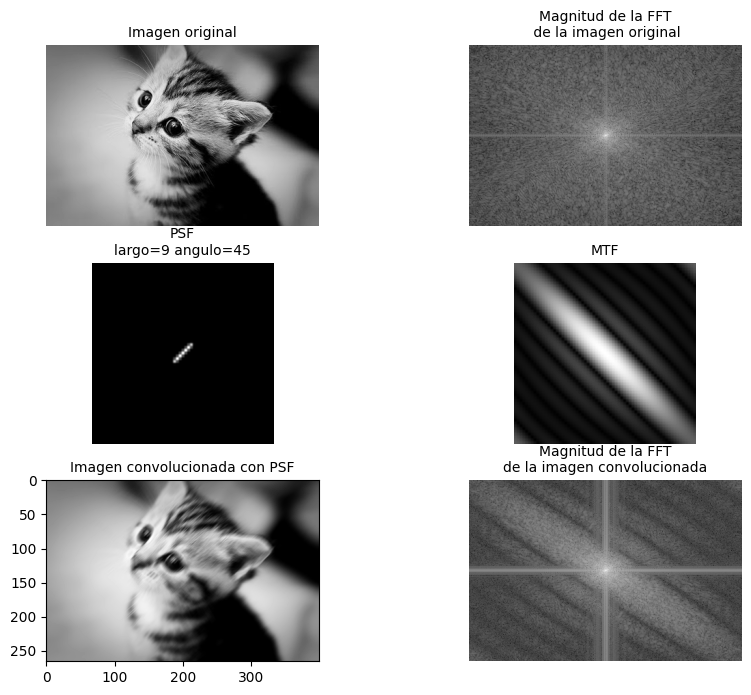

In [18]:
largo = 9
angulo = 45

kitten = cv2.imread('./imagenes/kitten.jpg', cv2.IMREAD_GRAYSCALE)
kitten_fft = np.abs(fftshift(fft2(kitten))) # magnitud de la transformada de fourier

psf = motionPSF(largo, angulo)
mtf = np.abs(fftshift(fft2(psf)))

kitten_conv = convolve(kitten, psf)
kitten_conv_fft = np.abs(fftshift(fft2(kitten_conv)))

fig, ax = plt.subplots(3, 2, figsize=(10, 8))

ax[0,0].imshow(kitten, cmap='gray')
ax[0,0].set_title('Imagen original', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(np.log(kitten_fft + 1), cmap='gray')
ax[0,1].set_title('Magnitud de la FFT\n de la imagen original', fontsize=10)
ax[0,1].axis('off')

ax[1,0].imshow(np.log(psf + 1), cmap='gray')
ax[1,0].set_title(f'PSF\nlargo={largo} angulo={angulo}', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(np.log(mtf + 1), cmap='gray')
ax[1,1].set_title('MTF', fontsize=10)
ax[1,1].axis('off')

ax[2,0].imshow(kitten_conv, cmap='gray')
ax[2,0].set_title('Imagen convolucionada con PSF', fontsize=10)
ax[0,0].axis('off')

ax[2,1].imshow(np.log(kitten_conv_fft + 1), cmap='gray')
ax[2,1].set_title('Magnitud de la FFT\nde la imagen convolucionada', fontsize=10)
ax[2,1].axis('off')

**b) Se busca hacer visible el número de matrícula en las imágenes blurred1.png, blurred2.png, blurred3.png.  
Intente restaurar las imágenes utilizando las siguientes técnicas:**

* Filtrado inverso (implementar)   
* Filtrado pseudo inverso (implementar)    
* Filtrado de Wiener (usar la función “wiener” del paquete skimage.restoration con diversos parámetros)
* Probar un método iterativo de deconvolución (p.ej Richardson-Lucy) con un paquete de scikit-image o Deconvolution-Lab en Fiji

In [19]:
def filtrado_inverso(img, h):
    """
    Filtro con 1/H
    """
    img_fft = fftshift(fft2(img))           # transfromada de Fourier de img
    H = fftshift(fft2(h, shape=img.shape))  # transfromada de Fourier de h

    # Filtro con 1/H
    img_filtrada_fft = img_fft*(1/H)        # aplico filtro

    # Antitransformo y tomo el modulo
    img_filtrada = ifft2(img_filtrada_fft)  # antitransformo la imagen resultante

    return np.abs(img_filtrada)

def filtrado_pseudo_inverso(img, h, cte):
    """
    Filtro con 1/(H+cte)
    """
    img_fft = fftshift(fft2(img))           # transfromada de Fourier de img
    H = fftshift(fft2(h, shape=img.shape))  # transfromada de Fourier de h

    # Filtro con 1/H
    img_filtrada_fft = img_fft*(1/(H+cte))  # aplico filtro

    # Antitransformo y tomo el modulo
    img_filtrada = ifft2(img_filtrada_fft)  # antitransformo la imagen resultante

    return np.abs(img_filtrada)

(-0.5, 767.5, 621.5, -0.5)

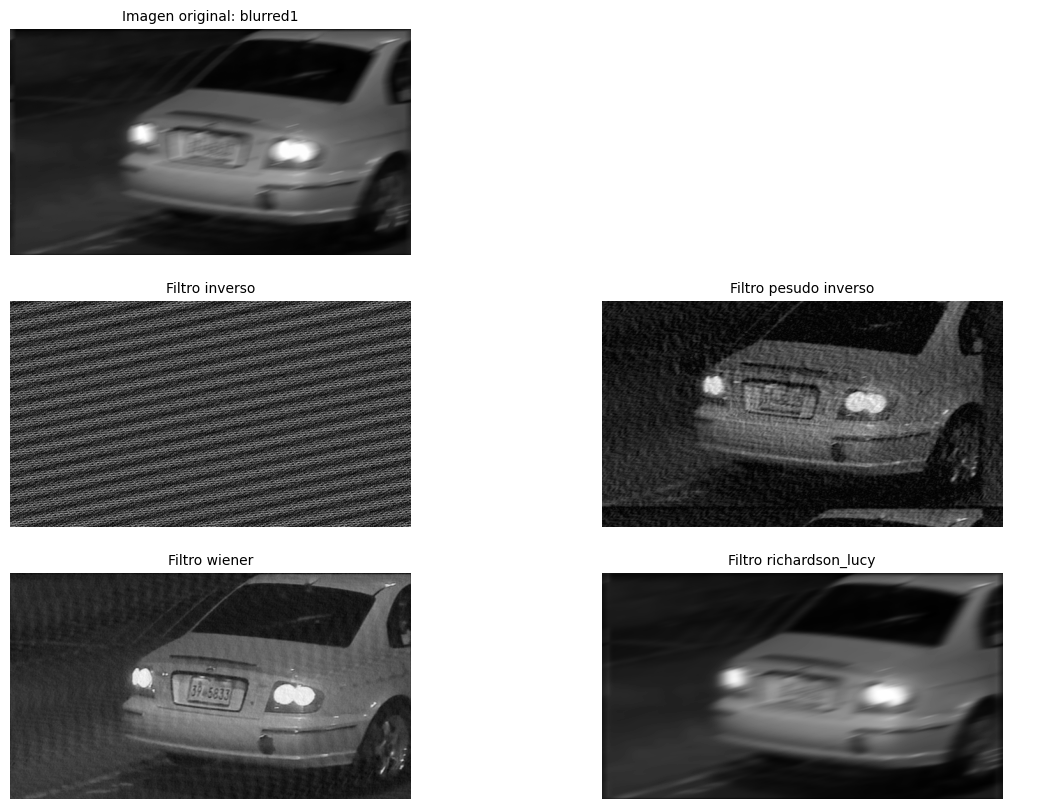

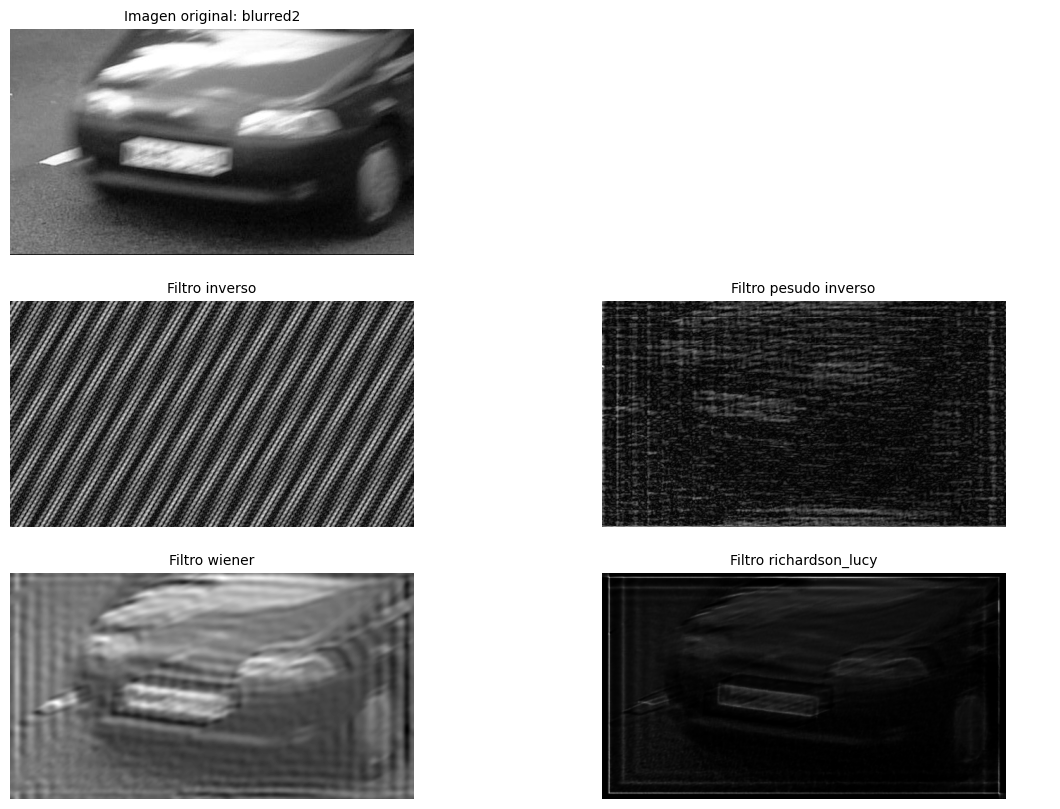

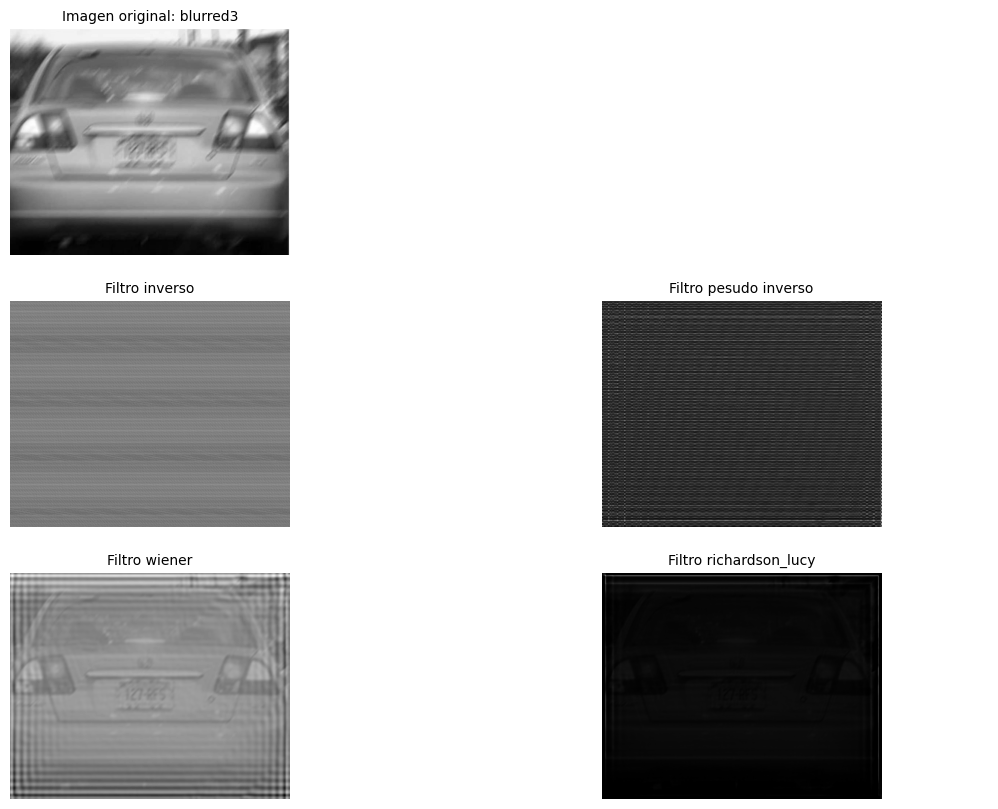

In [20]:
blurred1 = cv2.imread('./imagenes/blurred1.png', cv2.IMREAD_GRAYSCALE)
blurred2 = cv2.imread('./imagenes/blurred2.png', cv2.IMREAD_GRAYSCALE)
blurred3 = cv2.imread('./imagenes/blurred3.png', cv2.IMREAD_GRAYSCALE)

psf_blurred1 = motionPSF(20, 15)
blurred1_filtr_inv = filtrado_inverso(blurred1, psf_blurred1)
blurred1_filtr_pseudo_inv = filtrado_pseudo_inverso(blurred1, psf_blurred1, 0.1)
blurred1_wiener = wiener(blurred1, psf_blurred1, balance=0.0001, clip=False)
blurred1_richardson_lucy = richardson_lucy(blurred1, psf_blurred1, clip=False, num_iter=1)

psf_blurred2 = motionPSF(24, 36)
blurred2_filtr_inv = filtrado_inverso(blurred2, psf_blurred2)
blurred2_filtr_pseudo_inv = filtrado_pseudo_inverso(blurred2, psf_blurred2, 0.1)
blurred2_wiener = wiener(blurred2, psf_blurred2, balance=0.7, clip=False)
blurred2_richardson_lucy = richardson_lucy(blurred2, psf_blurred2, clip=False)

psf_blurred3 = motionPSF(28, 46)
blurred3_filtr_inv = filtrado_inverso(blurred3, psf_blurred3)
blurred3_filtr_pseudo_inv = filtrado_pseudo_inverso(blurred3, psf_blurred3, 0.1)
blurred3_wiener = wiener(blurred3, psf_blurred3, balance=0.5, clip=False)
blurred3_richardson_lucy = richardson_lucy(blurred3, psf_blurred3, clip=False)

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

ax[0,0].imshow(blurred1, cmap='gray')
ax[0,0].set_title('Imagen original: blurred1', fontsize=10)
ax[0,0].axis('off')

ax[0,1].axis('off')

ax[1,0].imshow(blurred1_filtr_inv, cmap='gray')
ax[1,0].set_title('Filtro inverso', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(blurred1_filtr_pseudo_inv, cmap='gray')
ax[1,1].set_title('Filtro pesudo inverso', fontsize=10)
ax[1,1].axis('off')

ax[2,0].imshow(blurred1_wiener, cmap='gray')
ax[2,0].set_title('Filtro wiener', fontsize=10)
ax[2,0].axis('off')

ax[2,1].imshow(blurred1_richardson_lucy, cmap='gray')
ax[2,1].set_title('Filtro richardson_lucy', fontsize=10)
ax[2,1].axis('off')

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

ax[0,0].imshow(blurred2, cmap='gray')
ax[0,0].set_title('Imagen original: blurred2', fontsize=10)
ax[0,0].axis('off')

ax[0,1].axis('off')

ax[1,0].imshow(blurred2_filtr_inv, cmap='gray')
ax[1,0].set_title('Filtro inverso', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(blurred2_filtr_pseudo_inv, cmap='gray')
ax[1,1].set_title('Filtro pesudo inverso', fontsize=10)
ax[1,1].axis('off')

ax[2,0].imshow(blurred2_wiener, cmap='gray')
ax[2,0].set_title('Filtro wiener', fontsize=10)
ax[2,0].axis('off')

ax[2,1].imshow(blurred2_richardson_lucy, cmap='gray')
ax[2,1].set_title('Filtro richardson_lucy', fontsize=10)
ax[2,1].axis('off')

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

ax[0,0].imshow(blurred3, cmap='gray')
ax[0,0].set_title('Imagen original: blurred3', fontsize=10)
ax[0,0].axis('off')

ax[0,1].axis('off')

ax[1,0].imshow(blurred3_filtr_inv, cmap='gray')
ax[1,0].set_title('Filtro inverso', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(blurred3_filtr_pseudo_inv, cmap='gray')
ax[1,1].set_title('Filtro pesudo inverso', fontsize=10)
ax[1,1].axis('off')

ax[2,0].imshow(blurred3_wiener, cmap='gray')
ax[2,0].set_title('Filtro wiener', fontsize=10)
ax[2,0].axis('off')

ax[2,1].imshow(blurred3_richardson_lucy, cmap='gray')
ax[2,1].set_title('Filtro richardson_lucy', fontsize=10)
ax[2,1].axis('off')


Para cada imagen se midió el largo y ángulo del movimiento en Fiji. Luego implementando los filtros se probó variar los parámetros de los filtros, no obteniendo los resultados esperados.

Matrícula blurred1: 395833

Matrícula blurred1: No se logra ver

Matrícula blurred3: 1272F5

## 5) Eliminación de ruido estructurado 

Las imágenes “radiografía1.png“y “radiografía2.png”  se encuentran contaminadas con ruido con cierta estructura.    

a) Visualizar las imágenes junto con sus transformadas DFT. Determinar las características del ruido.

Text(0.5, 1.0, 'radiografia2 fft')

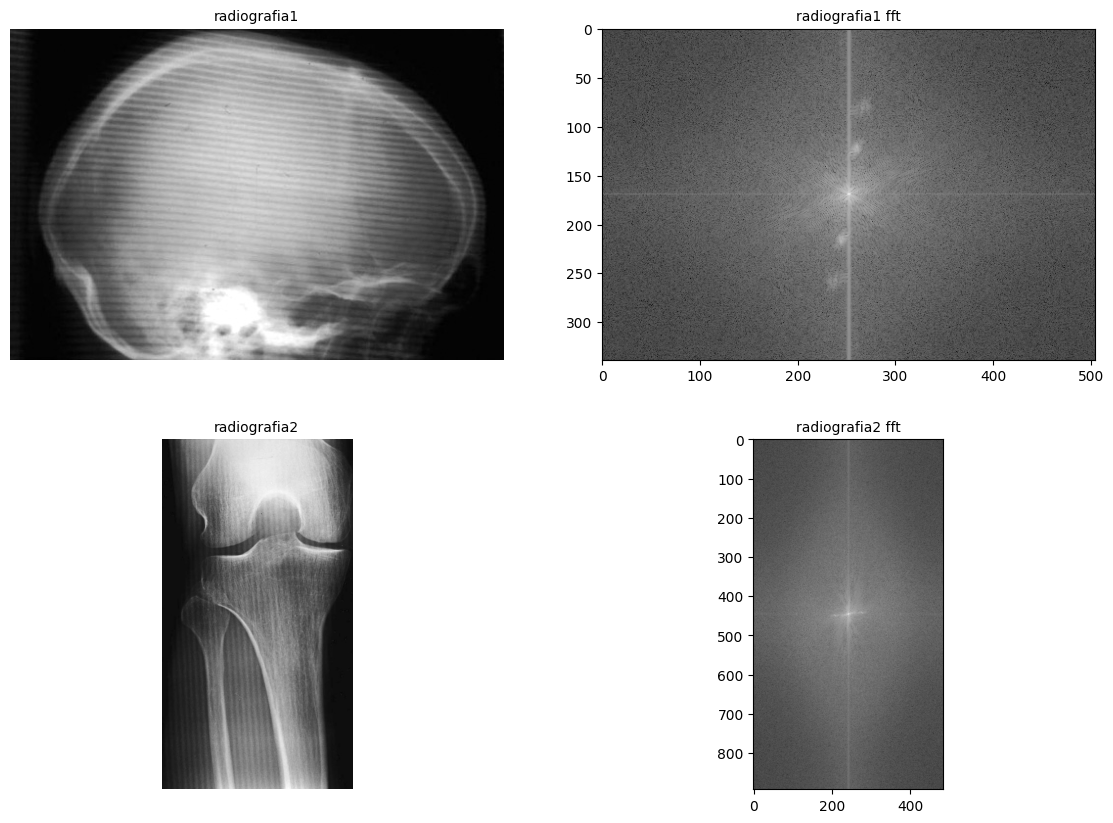

In [21]:
radiografia1 = cv2.imread(os.path.join(dir_base_imagenes, 'radiografia1.png'), cv2.IMREAD_GRAYSCALE)
radiografia2 = cv2.imread(os.path.join(dir_base_imagenes, 'radiografia2.png'), cv2.IMREAD_GRAYSCALE)

radiografia1_fft = fftshift(fft2(radiografia1, shape=radiografia1.shape))
radiografia2_fft = fftshift(fft2(radiografia2, shape=radiografia2.shape))

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].imshow(np.abs(radiografia1), cmap='gray')
ax[0,0].set_title('radiografia1', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(np.log(np.abs(radiografia1_fft)+1), cmap='gray')
ax[0,1].set_title('radiografia1 fft', fontsize=10)

ax[1,0].imshow(np.abs(radiografia2), cmap='gray')
ax[1,0].set_title('radiografia2', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(np.log(np.abs(radiografia2_fft)+1), cmap='gray')
ax[1,1].set_title('radiografia2 fft', fontsize=10)


_Comentario_:

Se puede observar al ruido como deltas en el espectro. Se procede a diseñar un filtro para filtrar esas deltas

b) Para cada una de ellas diseñar un filtro que permita eliminar la interferencia tanto como sea posible. Los filtros a utilizar serán de la forma    

$$ H(u,v) = \prod_{i=1}^N \left( 1 - \exp \left( \frac{-(u-{u_0}_i)^2 - (v-{v_0}_i)^2}{\sigma_i^2} \right) \right) $$


Explicar el procedimiento utilizado para diseñar el filtro indicando los valores de los parámetros elegidos. 

Implementar una función que, dadas las componentes de frecuencia a filtrar, devuelva el filtro H.


In [22]:
def H(u_0, v_0, sigma, shape):
    """
    Calcula el filtro H

    Args:
        u_0 (np.array)
        v_0 (np.array)
        sigma (np.array
        shape (tuple): dimensiones del filtro a calcular

    Returns:
        _type_: _description_
    """
    H = np.empty(shape)
    for v in range(H.shape[0]):
        for u in range(H.shape[1]):
            h_uv = 1
            for u_i, v_i, sigma_i in zip(u_0, v_0, sigma):
                h_uv = h_uv * (1- np.exp((-(u-u_i)**2-(v-v_i)**2) / sigma_i**2))
            H[v, u] = h_uv

    return H

El filtro H es un filtro pasabanda. Deja pasar todas las frecuencias excepto en un entorno de ${u_0}_i$, ${v_0}_i$, donde se atenúan mediante una gaussiana negativa centrada en ${u_0}_i$, ${v_0}_i$ de varianza $\sigma_i$ para anular dichas frecuencias

**c)** Filtrar las imágenes de radiografías. Analizar los resultados (imagen original, imagen filtrada, ruido eliminado) en el espacio y en frecuencia)

(893, 485)


Text(0.5, 1.0, 'radiografia 2 filtrada fft')

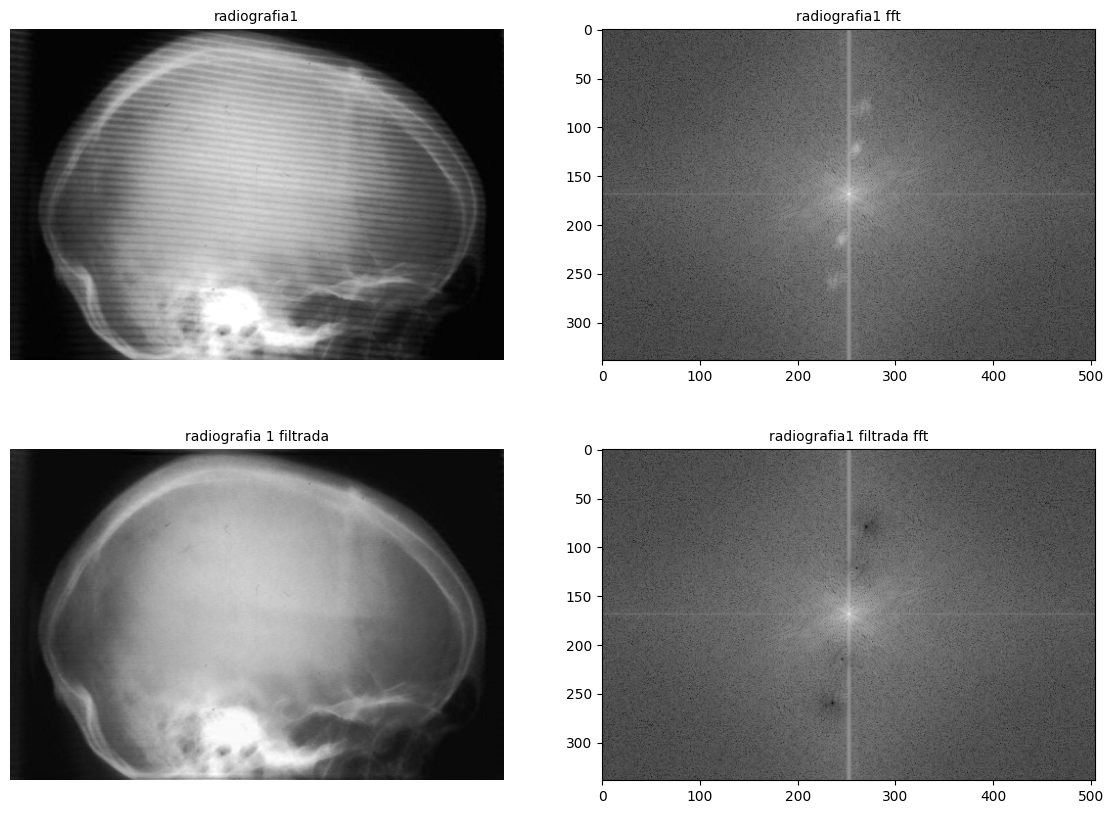

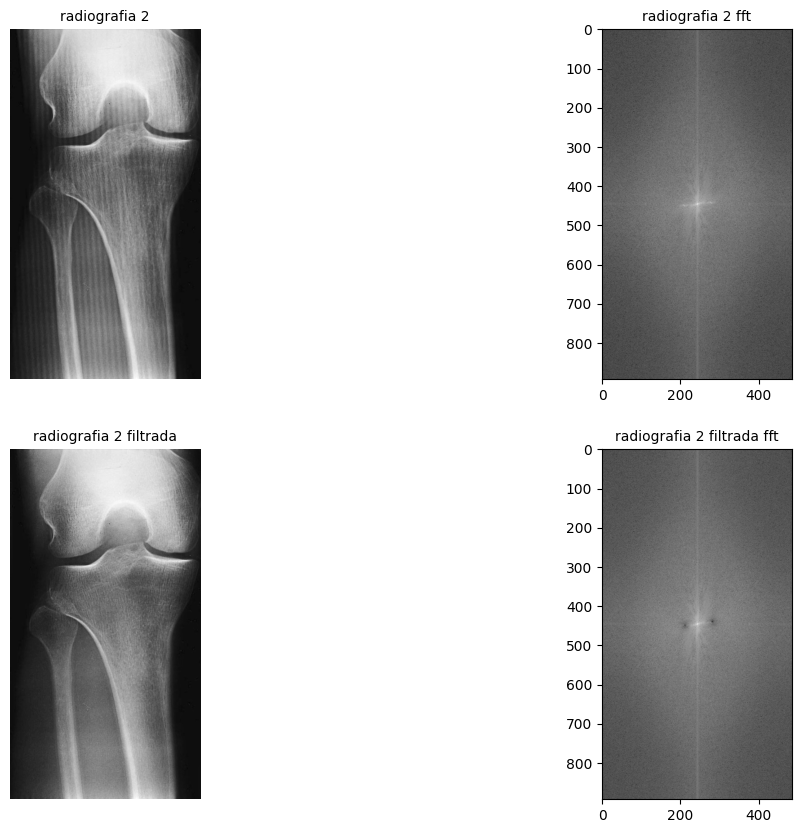

In [23]:
u_0 = [260, 270, 245, 235]
v_0 = [122, 80, 215, 260]
sigma = [20, 20, 20, 20]

print(radiografia2.shape)

radiografia1_filtrada_fft = radiografia1_fft * H(u_0, v_0, sigma, shape=radiografia1_fft.shape)
radiografia1_filtrada = ifft2(radiografia1_filtrada_fft)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].imshow(np.abs(radiografia1), cmap='gray')
ax[0,0].set_title('radiografia1', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(np.log(np.abs(radiografia1_fft)+1), cmap='gray')
ax[0,1].set_title('radiografia1 fft', fontsize=10)

ax[1,0].imshow(np.abs(radiografia1_filtrada), cmap='gray')
ax[1,0].set_title('radiografia 1 filtrada', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(np.log(np.abs(radiografia1_filtrada_fft)+1), cmap='gray')
ax[1,1].set_title('radiografia1 filtrada fft', fontsize=10)


u_0 = [210, 280]
v_0 = [450, 440]
sigma = [20, 20]

radiografia2_filtrada_fft = radiografia2_fft * H(u_0, v_0, sigma, shape=radiografia2_fft.shape)
radiografia2_filtrada = ifft2(radiografia2_filtrada_fft)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].imshow(np.abs(radiografia2), cmap='gray')
ax[0,0].set_title('radiografia 2', fontsize=10)
ax[0,0].axis('off')

ax[0,1].imshow(np.log(np.abs(radiografia2_fft)+1), cmap='gray')
ax[0,1].set_title('radiografia 2 fft', fontsize=10)

ax[1,0].imshow(np.abs(radiografia2_filtrada), cmap='gray')
ax[1,0].set_title('radiografia 2 filtrada', fontsize=10)
ax[1,0].axis('off')

ax[1,1].imshow(np.log(np.abs(radiografia2_filtrada_fft)+1), cmap='gray')
ax[1,1].set_title('radiografia 2 filtrada fft', fontsize=10)



Se ha logrado encontrar las coordenadas en el espectro de las deltas que se quieren filtrar. Luego utilizando el filtro H para filtrar en frecuencia y volver al espacio se logra ver cómo se quitó con éxito el ruido

**d)** **_Opcional_:** mostrar cómo se puede hacer en Fiji (a mano o mediante una macro)